In [2]:
!apt-get install -y poppler-utils
!pip install wfdb torch-geometric scipy numpy
!pip install git+https://github.com/UMMISCO/ecgtizer.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 186 kB in 1s (229 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install xmltodict reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00


In [5]:
from PIL import Image, ImageEnhance
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Configuration
DATASET_DIR = "/content/drive/MyDrive/ecg_signals_new"  # ECG images folder organized by class
OUTPUT_DIR = "/content/drive/MyDrive/fine_tune_dataset_npy"  # Where converted .npy signals will be saved
lead_order = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

def preprocess_image(image_path, contrast_factor=2.0):
    img = Image.open(image_path).convert("L")
    enhancer = ImageEnhance.Contrast(img)
    img_enhanced = enhancer.enhance(contrast_factor)
    return img_enhanced

def digitize_image(image_path):
    from ecgtizer import ECGtizer
    img = preprocess_image(image_path)
    temp_path = "/tmp/temp_ecg.png"
    img.save(temp_path)
    ecg = ECGtizer(temp_path, dpi=500, extraction_method="full", verbose=False, DEBUG=False)

    max_len = 0
    for lead in lead_order:
        if lead in ecg.extracted_lead:
            max_len = max(max_len, len(ecg.extracted_lead[lead]))

    lead_arrays = []
    for lead in lead_order:
        if lead in ecg.extracted_lead:
            arr = np.array(ecg.extracted_lead[lead])
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), mode='edge')
        else:
            arr = np.zeros(max_len)
        lead_arrays.append(arr)
    signal = np.column_stack(lead_arrays).astype(np.float32)

    # Impute missing leads by averaging neighbors
    for i, lead in enumerate(lead_order):
        if np.all(signal[:, i] == 0):
            left = max(i-1, 0)
            right = min(i+1, len(lead_order)-1)
            signal[:, i] = (signal[:, left] + signal[:, right]) / 2

    return signal

def convert_dataset_to_npy(dataset_dir, output_dir):
    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    classes = [d.name for d in dataset_dir.iterdir() if d.is_dir()]
    print(f"Classes found: {classes}")

    for cls in classes:
        input_class_dir = dataset_dir / cls
        output_class_dir = output_dir / cls
        output_class_dir.mkdir(parents=True, exist_ok=True)
        image_files = list(input_class_dir.glob("*.jpg")) + list(input_class_dir.glob("*.png"))
        print(f"Converting {len(image_files)} images from class {cls}")

        for img_path in tqdm(image_files, desc=f"Converting {cls}"):
            try:
                signal = digitize_image(str(img_path))
                npy_path = output_class_dir / (img_path.stem + ".npy")
                np.save(str(npy_path), signal)
            except Exception as e:
                print(f"Failed conversion for {img_path}: {e}")

    print("Conversion complete.")

if __name__ == "__main__":
    convert_dataset_to_npy(DATASET_DIR, OUTPUT_DIR)


Classes found: ['STTC', 'HYP', 'MI', 'NORM', 'CD']
Converting 172 images from class STTC


Converting STTC: 100%|██████████| 172/172 [01:47<00:00,  1.60it/s]


Converting 233 images from class HYP


Converting HYP: 100%|██████████| 233/233 [02:31<00:00,  1.53it/s]


Converting 239 images from class MI


Converting MI: 100%|██████████| 239/239 [02:29<00:00,  1.60it/s]


Converting 284 images from class NORM


Converting NORM: 100%|██████████| 284/284 [02:48<00:00,  1.68it/s]


Converting 5 images from class CD


Converting CD: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

Conversion complete.


Fine-tuning on device: cuda
Loaded 933 samples from /content/drive/MyDrive/fine_tune_dataset_npy
Loaded pretrained weights.


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.28it/s]


Epoch 1/50 Train Loss: 3.9123 Train Acc: 21.45% Val Loss: 3.3948 Val Acc: 14.44%
Saved best model with val acc 14.44%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.20it/s]


Epoch 2/50 Train Loss: 3.0753 Train Acc: 19.44% Val Loss: 2.6685 Val Acc: 13.37%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.97it/s]


Epoch 3/50 Train Loss: 2.0788 Train Acc: 20.24% Val Loss: 2.1797 Val Acc: 22.99%
Saved best model with val acc 22.99%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.68it/s]


Epoch 4/50 Train Loss: 1.5699 Train Acc: 30.16% Val Loss: 1.6613 Val Acc: 36.90%
Saved best model with val acc 36.90%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.91it/s]


Epoch 5/50 Train Loss: 1.3458 Train Acc: 47.32% Val Loss: 1.4447 Val Acc: 47.06%
Saved best model with val acc 47.06%


Validating: 100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


Epoch 6/50 Train Loss: 1.3013 Train Acc: 48.39% Val Loss: 1.3317 Val Acc: 46.52%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]


Epoch 7/50 Train Loss: 1.2376 Train Acc: 49.06% Val Loss: 1.2782 Val Acc: 41.71%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]


Epoch 8/50 Train Loss: 1.2189 Train Acc: 49.73% Val Loss: 1.2899 Val Acc: 44.92%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]


Epoch 9/50 Train Loss: 1.2055 Train Acc: 50.13% Val Loss: 1.2461 Val Acc: 48.66%
Saved best model with val acc 48.66%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.70it/s]


Epoch 10/50 Train Loss: 1.1840 Train Acc: 51.74% Val Loss: 1.2816 Val Acc: 46.52%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.39it/s]


Epoch 11/50 Train Loss: 1.1573 Train Acc: 53.22% Val Loss: 1.2323 Val Acc: 47.06%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.06it/s]


Epoch 12/50 Train Loss: 1.1634 Train Acc: 50.94% Val Loss: 1.3094 Val Acc: 42.25%


Validating: 100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 13/50 Train Loss: 1.1765 Train Acc: 52.28% Val Loss: 1.2515 Val Acc: 45.45%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.21it/s]


Epoch 14/50 Train Loss: 1.1124 Train Acc: 53.75% Val Loss: 1.2236 Val Acc: 47.59%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.90it/s]


Epoch 15/50 Train Loss: 1.0851 Train Acc: 53.35% Val Loss: 1.1919 Val Acc: 52.41%
Saved best model with val acc 52.41%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.85it/s]


Epoch 16/50 Train Loss: 1.1103 Train Acc: 55.09% Val Loss: 1.2361 Val Acc: 44.92%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.75it/s]


Epoch 17/50 Train Loss: 1.1195 Train Acc: 54.02% Val Loss: 1.1610 Val Acc: 50.80%


Validating: 100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 18/50 Train Loss: 1.0992 Train Acc: 53.49% Val Loss: 1.1506 Val Acc: 52.94%
Saved best model with val acc 52.94%


Validating: 100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


Epoch 19/50 Train Loss: 1.0817 Train Acc: 55.23% Val Loss: 1.1325 Val Acc: 52.94%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.24it/s]


Epoch 20/50 Train Loss: 1.1100 Train Acc: 54.16% Val Loss: 1.1722 Val Acc: 50.27%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.31it/s]


Epoch 21/50 Train Loss: 1.1098 Train Acc: 53.62% Val Loss: 1.1934 Val Acc: 48.13%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.37it/s]


Epoch 22/50 Train Loss: 1.0673 Train Acc: 54.56% Val Loss: 1.1842 Val Acc: 49.20%


Validating: 100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 23/50 Train Loss: 1.0375 Train Acc: 56.84% Val Loss: 1.1662 Val Acc: 49.73%


Validating: 100%|██████████| 12/12 [00:00<00:00, 14.19it/s]


Epoch 24/50 Train Loss: 1.0642 Train Acc: 56.97% Val Loss: 1.1423 Val Acc: 52.41%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.28it/s]


Epoch 25/50 Train Loss: 1.0370 Train Acc: 58.58% Val Loss: 1.1300 Val Acc: 49.20%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.93it/s]


Epoch 26/50 Train Loss: 1.0453 Train Acc: 57.37% Val Loss: 1.1248 Val Acc: 48.66%


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]


Epoch 27/50 Train Loss: 1.0557 Train Acc: 57.10% Val Loss: 1.1325 Val Acc: 48.66%


Validating: 100%|██████████| 12/12 [00:01<00:00,  9.91it/s]


Epoch 28/50 Train Loss: 1.0123 Train Acc: 59.25% Val Loss: 1.1895 Val Acc: 49.73%
Early stopping triggered at epoch 28


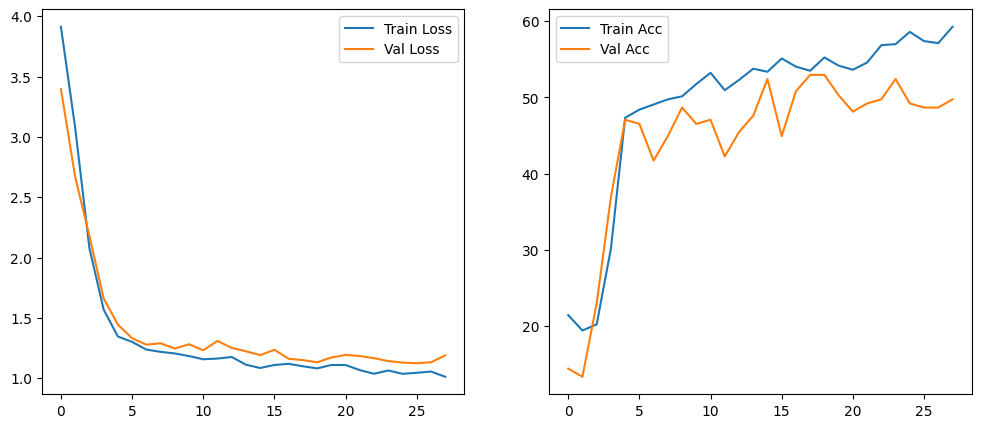

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt


# Configuration
CONFIG = {
    "DATASET_DIR": "/content/drive/MyDrive/fine_tune_dataset_npy",  # Your .npy signals dataset folder
    "BATCH_SIZE": 16,
    "EPOCHS": 50,
    "LEARNING_RATE": 1e-4,
    "WEIGHT_DECAY": 1e-5,
    "NUM_CLASSES": 5,
    "DROPOUT": 0.3,
    "WARMUP_EPOCHS": 5,
    "CHECKPOINT_DIR": "/content/checkpoints",
    "MODEL_WEIGHTS_PATH": "/content/drive/MyDrive/ECG MODELS/best_cnn_gnn_final.pt",
}


class_map = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}
lead_order = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]


# Dataset loader with on-the-fly augmentation and imputation
class ECGSignalDataset(Dataset):
    def __init__(self, dataset_dir, augment=True):
        self.dataset_dir = Path(dataset_dir)
        self.augment = augment
        self.samples = []
        self._load_samples()

    def _load_samples(self):
        for class_name, class_idx in class_map.items():
            class_folder = self.dataset_dir / class_name
            if not class_folder.exists():
                print(f"Warning: Class folder {class_name} not found.")
                continue
            for npy_file in class_folder.glob("*.npy"):
                self.samples.append((npy_file, class_idx))
        print(f"Loaded {len(self.samples)} samples from {self.dataset_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        npy_path, label = self.samples[idx]
        signal = np.load(npy_path).astype(np.float32)

        fixed_length = 1000
        if signal.shape[0] < fixed_length:
            pad_width = fixed_length - signal.shape[0]
            signal = np.pad(signal, ((0, pad_width), (0, 0)), mode='edge')
        elif signal.shape[0] > fixed_length:
            signal = signal[:fixed_length]

        # Missing-lead augmentation
        if self.augment:
            num_missing = np.random.randint(0, 4)
            missing_leads = np.random.choice(signal.shape[1], num_missing, replace=False)
            for lead_idx in missing_leads:
                signal[:, lead_idx] = 0

        # Impute missing leads
        for i in range(signal.shape[1]):
            if np.all(signal[:, i] == 0):
                left = max(i - 1, 0)
                right = min(i + 1, signal.shape[1] - 1)
                signal[:, i] = (signal[:, left] + signal[:, right]) / 2

        # Normalize signals
        mu = signal.mean(axis=0, keepdims=True)
        sd = signal.std(axis=0, keepdims=True) + 1e-8
        signal = (signal - mu) / sd

        return torch.from_numpy(signal).float(), torch.tensor(label, dtype=torch.long)


# CNN+GNN Model class (with dropout)
class CNNGNNModel(nn.Module):
    def __init__(self, input_leads=12, num_classes=5, dropout=0.3):
        super().__init__()
        self.cnn = nn.ModuleDict({
            'conv1': nn.Conv1d(1, 32, kernel_size=7, padding=3),
            'bn1': nn.BatchNorm1d(32),
            'conv2': nn.Conv1d(32, 64, kernel_size=5, padding=2),
            'bn2': nn.BatchNorm1d(64),
            'conv3': nn.Conv1d(64, 64, kernel_size=3, padding=1),
            'bn3': nn.BatchNorm1d(64),
        })
        self.dropout_cnn = nn.Dropout(dropout)
        self.gcn1 = GCNConv(64, 128)
        self.gcn2 = GCNConv(128, 128)
        self.dropout_gcn = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128, 64)
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x, edge_index=None):
        B, T, L = x.shape
        x_cnn = x.permute(0, 2, 1).reshape(B * L, 1, T)
        x_cnn = F.relu(self.cnn['bn1'](self.cnn['conv1'](x_cnn)))
        x_cnn = self.dropout_cnn(x_cnn)
        x_cnn = F.relu(self.cnn['bn2'](self.cnn['conv2'](x_cnn)))
        x_cnn = self.dropout_cnn(x_cnn)
        x_cnn = F.relu(self.cnn['bn3'](self.cnn['conv3'](x_cnn)))
        x_cnn = x_cnn.mean(dim=-1).reshape(B, L, 64)

        if edge_index is None:
            edge_index = self._build_edge_index(L, device=x.device)

        gcn_outs = []
        for i in range(B):
            gnn_input = x_cnn[i]
            gcn_out = F.relu(self.gcn1(gnn_input, edge_index))
            gcn_out = self.dropout_gcn(gcn_out)
            gcn_out = F.relu(self.gcn2(gcn_out, edge_index))
            gcn_out = self.dropout_gcn(gcn_out)
            pooled = gcn_out.mean(dim=0)
            gcn_outs.append(pooled)

        pooled = torch.stack(gcn_outs)  # Shape (B, 128)
        fc_out = F.relu(self.fc1(pooled))
        fc_out = self.dropout_fc(fc_out)
        logits = self.fc2(fc_out)  # Shape (B, num_classes)
        return logits

    def _build_edge_index(self, num_leads, device):
        rows, cols = [], []
        for i in range(num_leads):
            for j in range(num_leads):
                if i != j:
                    rows.append(i)
                    cols.append(j)
        return torch.tensor([rows, cols], dtype=torch.long, device=device)


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0


# Training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for signals, labels in tqdm(dataloader, desc="Training"):
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(dataloader), 100 * correct / total


# Validation loop
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for signals, labels in tqdm(dataloader, desc="Validating"):
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), 100 * correct / total


# Fine-tuning entry point
def fine_tune():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Fine-tuning on device: {device}")
    Path(CONFIG["CHECKPOINT_DIR"]).mkdir(exist_ok=True, parents=True)

    dataset = ECGSignalDataset(CONFIG["DATASET_DIR"], augment=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=2)

    model = CNNGNNModel(num_classes=CONFIG["NUM_CLASSES"], dropout=CONFIG["DROPOUT"]).to(device)
    if Path(CONFIG["MODEL_WEIGHTS_PATH"]).exists():
        state_dict = torch.load(CONFIG["MODEL_WEIGHTS_PATH"], map_location=device)
        model.load_state_dict(state_dict, strict=False)
        print("Loaded pretrained weights.")

    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["LEARNING_RATE"], weight_decay=CONFIG["WEIGHT_DECAY"])
    criterion = nn.CrossEntropyLoss()

    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    best_val_acc = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(CONFIG["EPOCHS"]):
        if epoch < CONFIG["WARMUP_EPOCHS"]:
            for param_group in optimizer.param_groups:
                param_group['lr'] = CONFIG["LEARNING_RATE"] * (epoch + 1) / CONFIG["WARMUP_EPOCHS"]
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), Path(CONFIG["CHECKPOINT_DIR"]) / "best_model.pt")
            print(f"Saved best model with val acc {best_val_acc:.2f}%")

        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    fine_tune()


In [6]:
from PIL import Image, ImageEnhance
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from scipy.signal import resample_poly

# Configuration
CONFIG = {
    "RAW_ECG_IMAGE": "/content/drive/MyDrive/ECG/Normal(240).jpg",
    "ECGTIZER_OUTPUT_DIR": "/content/ecgtizer_output",
    "MODEL_WEIGHTS_PATH": "/content/drive/MyDrive/ECG MODELS/best_cnn_gnn_final.pt",
    "DPI": 500,
    "EXTRACTION_METHOD": "full",
    "SOURCE_FS": 500,
    "TARGET_FS": 100,
    "DURATION_SEC": 10,
}

lead_order = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

# Step 1 Preprocessing: Enhance contrast and convert to grayscale png
def preprocess_image(input_path, output_path, contrast_factor=2.0):
    img = Image.open(input_path).convert("L")
    enhancer = ImageEnhance.Contrast(img)
    img_enhanced = enhancer.enhance(contrast_factor)
    img_enhanced.save(output_path)
    print(f"Contrast-enhanced ECG saved as {output_path}")

# Step 2 ECGtizer digitization
def run_ecgtizer(image_path, output_dir):
    from ecgtizer import ECGtizer
    ecg = ECGtizer(
        image_path,
        dpi=CONFIG['DPI'],
        extraction_method=CONFIG['EXTRACTION_METHOD'],
        verbose=True,
        DEBUG=False
    )
    print("\nExtracted lead keys:", list(ecg.extracted_lead.keys()))

    lead_arrays = []
    max_len = 0
    for lead in lead_order:
        if lead in ecg.extracted_lead:
            arr = np.array(ecg.extracted_lead[lead])
            max_len = max(max_len, len(arr))

    for lead in lead_order:
        if lead in ecg.extracted_lead:
            arr = np.array(ecg.extracted_lead[lead])
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), mode='edge')
        else:
            print(f"WARNING: Lead {lead} missing, padding zeros")
            arr = np.zeros(max_len)
        lead_arrays.append(arr)

    signal = np.column_stack(lead_arrays).astype(np.float32)
    Path(output_dir).mkdir(exist_ok=True, parents=True)
    npy_path = Path(output_dir) / "digitized.npy"
    np.save(str(npy_path), signal)
    print(f"Signals saved to {npy_path}, shape: {signal.shape}")
    return str(npy_path)

# Step 3 Impute missing leads
def impute_missing_leads(signal, lead_order):
    for i, lead in enumerate(lead_order):
        if np.all(signal[:, i] == 0):
            left = max(i - 1, 0)
            right = min(i + 1, len(lead_order) - 1)
            signal[:, i] = (signal[:, left] + signal[:, right]) / 2
            print(f"Imputed missing lead {lead} from neighbors.")
    return signal
import matplotlib.pyplot as plt

def plot_leads(signal, lead_order):
    num_leads = len(lead_order)
    plt.figure(figsize=(15, 2*num_leads))
    for i, lead in enumerate(lead_order):
        plt.subplot(num_leads, 1, i+1)
        plt.plot(signal[:, i])
        plt.title(f"Lead {lead}")
        plt.tight_layout()
    plt.show()

# Step 4 Signal standardization (resample & pad)
def standardize_signal(signal, fs_src, target_fs, duration_sec):
    print(f"\nStandardizing signal: {fs_src}Hz -> {target_fs}Hz")
    if fs_src != target_fs:
        from math import gcd
        up, down = target_fs, fs_src
        g = gcd(up, down)
        signal = resample_poly(signal, up // g, down // g, axis=0)
    target_samples = target_fs * duration_sec
    if signal.shape[0] > target_samples:
        signal = signal[:target_samples]
    elif signal.shape[0] < target_samples:
        signal = np.pad(signal, ((0, target_samples - signal.shape[0]), (0, 0)), mode='edge')
    return signal.astype(np.float32)

# Step 5 CNN+GNN model class
class CNNGNNModel(nn.Module):
    def __init__(self, input_leads=12, input_length=1000, num_classes=5):
        super().__init__()
        # CNN layers (exactly like checkpoint)
        self.cnn = nn.Module()
        self.cnn.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.cnn.bn1 = nn.BatchNorm1d(32)
        self.cnn.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.cnn.bn2 = nn.BatchNorm1d(64)
        self.cnn.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.cnn.bn3 = nn.BatchNorm1d(64)

        # GNN layers
        self.gcn1 = GCNConv(64, 128)
        self.gcn2 = GCNConv(128, 128)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.input_leads = input_leads

    def forward(self, x, edge_index=None):
        B, T, L = x.shape
        x_cnn = x.permute(0, 2, 1).reshape(B * L, 1, T)

        x_cnn = F.relu(self.cnn.bn1(self.cnn.conv1(x_cnn)))
        x_cnn = F.relu(self.cnn.bn2(self.cnn.conv2(x_cnn)))
        x_cnn = F.relu(self.cnn.bn3(self.cnn.conv3(x_cnn)))
        x_cnn = x_cnn.mean(dim=-1).reshape(B, L, 64)

        gnn_input = x_cnn[0]
        if edge_index is None:
            edge_index = self._build_edge_index(L, device=x.device)

        gcn_out = F.relu(self.gcn1(gnn_input, edge_index))
        gcn_out = F.relu(self.gcn2(gcn_out, edge_index))

        pooled = gcn_out.mean(dim=0)
        fc_out = F.relu(self.fc1(pooled))
        logits = self.fc2(fc_out)
        return logits.unsqueeze(0)

    def _build_edge_index(self, num_leads, device):
        rows, cols = [], []
        for i in range(num_leads):
            for j in range(num_leads):
                if i != j:
                    rows.append(i)
                    cols.append(j)
        return torch.tensor([rows, cols], dtype=torch.long, device=device)

# Step 6 Load model weights
def load_model(weights_path, device):
    print("\nLoading CNN+GNN model...")
    model = CNNGNNModel().to(device)
    if Path(weights_path).exists():
        state_dict = torch.load(weights_path, map_location=device)
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        print(f"Model loaded with missing keys: {missing}, unexpected keys: {unexpected}")
    else:
        print("Model weights not found, initializing randomly.")
    model.eval()
    return model

# Step 7 Predict on input
def predict(model, signal, device):
    print("\nRunning inference...")
    mu = signal.mean(axis=0, keepdims=True)
    sd = signal.std(axis=0, keepdims=True) + 1e-8
    signal_norm = (signal - mu) / sd
    x = torch.from_numpy(signal_norm).float().unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy().ravel()
    classes = ['normal', 'myocardial_infarction', 'hypertrophy', 'sttc', 'cd']
    return dict(zip(classes, probs))

# Step 8 Main pipeline run
def main():
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {device}")

    preprocessed_path = "/content/HB-67-enhanced.png"
    preprocess_image(CONFIG["RAW_ECG_IMAGE"], preprocessed_path)

    npy_file = run_ecgtizer(preprocessed_path, CONFIG["ECGTIZER_OUTPUT_DIR"])
    signal = np.load(npy_file)

    signal = impute_missing_leads(signal, lead_order)

    signal_std = standardize_signal(signal, CONFIG["SOURCE_FS"], CONFIG["TARGET_FS"], CONFIG["DURATION_SEC"])

    model = load_model(CONFIG["MODEL_WEIGHTS_PATH"], device)

    probs = predict(model, signal_std, device)

    print("\n===== Predicted Class Probabilities =====")
    for cls, prob in probs.items():
        bar = "█" * int(prob * 40)
        print(f"{cls:<20} {prob:.4f} {bar}")
    print("=" * 40)

if __name__ == "__main__":
    main()


Running on device: cuda
Contrast-enhanced ECG saved as /content/HB-67-enhanced.png


--- Open Image : 			OK (-0.03sec) 

--- Check Quality and Type of image : 		OK (-0.14sec) 

TYPE classic
--- Extract all the text from the image : 	OK (-0.03sec) 

--- Detect tracks position : 			OK (-0.04sec) 

--- Tracks extraction : 			OK (-0.39sec) 

--- Lead detection : 				OK (-0.0sec) 


Extracted lead keys: ['I', 'V1', 'II', 'V2', 'III', 'V3', 'AVR', 'V4', 'AVL', 'V5', 'AVF', 'V6']
Signals saved to /content/ecgtizer_output/digitized.npy, shape: (5000, 12)
Imputed missing lead aVR from neighbors.
Imputed missing lead aVL from neighbors.
Imputed missing lead aVF from neighbors.
Imputed missing lead V6 from neighbors.

Standardizing signal: 500Hz -> 100Hz

Loading CNN+GNN model...
Model loaded with missing keys: [], unexpected keys: []

Running inference...

===== Predicted Class Probabilities =====
normal               0.0000 
myocardial_infarction 0.0000 
hypertrophy          0.0005 
sttc       